<div style="text-align: right"> 
<a href = "https://nbviewer.jupyter.org/github/siddharthchaini/Improving-Feature-Extraction-RESSPECT/tree/main/"> 
    View online on<br>
    <img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg"
         alt="nbviewer link" style="height: 30px;"/> 
</a>
</div>

# 2. GP-VAE Approach for RESSPECT
<a href = http://cosmostatistics-initiative.org/resspect/>
<img src="https://cosmostatistics-initiative.org/wp-content/uploads/2019/04/coin_desc_3.png" alt="Logo" style="width: 250px;"/>
</a>

**Authors**: Siddharth Chaini, Johann Cohen-Tanugi

This is the second Jupyter notebook (of a total of 2) describing the different feature extraction methods explored by Siddharth and Johann in June & July, 2021.

For RESSPECT, a light curve is fit to a function and then the fit parameters are then used in the RESSPECT pipeline as features for training. You can read more about this here: https://arxiv.org/pdf/2010.05941.pdf

In this notebook, we will look at a deep learning based approach for feature extraction, GP-VAE.

In [1]:
import datetime
print('Last Updated On:', datetime.datetime.now().strftime("%d %B, %Y"))

Last Updated On: 29 July, 2021


In [2]:
# Some prerequisites

import numpy as np
np.random.seed(42)
np.set_printoptions(suppress=True)
from scipy.optimize import least_squares, curve_fit
from matplotlib import pylab as plt
import pandas as pd
import glob
import time
from tqdm.notebook import tqdm
import os

import warnings
from scipy.optimize import OptimizeWarning
warnings.simplefilter("error", OptimizeWarning)

import seaborn as sns
sns.set()

def plot_allbands_df(df,title=None,ax=plt):
    ugrizYcolors = ["violet","green","red","darkred","grey","black"]
    for i,band in enumerate("ugrizY"):
        subdf = df[df["band"]==band].reset_index(drop=True)
        x = subdf["mjd"]
        y = subdf["flux"]
        yerr = subdf["fluxerr"]
#         ax.errorbar(x,y,yerr=yerr,ls = "None",color=ugrizYcolors[i])
        ax.scatter(x,y,s=5,label=band,color=ugrizYcolors[i])
        if title is not None:
            if ax is not plt:
                ax.set_title(title)
            else:
                ax.title(title)
    return ax


### 2.1 About GP-VAE

Gaussian-Process Variational Autoencoders (GP-VAE ; [Fortuin et. al. 2020](https://arxiv.org/pdf/1907.04155.pdf)) is an approach developed for dimensionality reduction and data imputation. It combines Variational Autoencoders (VAEs) with Gaussian Processes (GPs) in the following way:

- Deep VAEs are used to map the original time series data with missing values into a latent space.
- A GP then utilizes latent representations to capture the temporal correlations in the time series.

A detailed description of this is available in [Fortuin et. al. (2020)](https://arxiv.org/pdf/1907.04155.pdf).

For our use case, we wish to use the latent space of the GP-VAE as features for the light curves in 6 passbands. We use code provided by the authors on [GitHub](https://github.com/ratschlab/GP-VAE)<sup>[*](#myfootnote1)</sup>.

<a name="myfootnote1">*</a> Note: The original code was based on TensorFlow 1.15 and so we made small modifications on a [fork](https://github.com/siddharthchaini/GP-VAE) using [TensorFlow's Upgrade Script](https://www.tensorflow.org/guide/upgrade) to make it compatible for TensorFlow 2+.

### 2.2 Data & Preprocessing

PLAsTiCC/RESSPECT data consists of light-curve data in the form of CSVs with readings at a particular timestamp, indicating the mjd of observation, the passband in which it was observed, and the flux values and flux errors.

For example:

In [3]:
df = pd.read_csv("sample_data/plasticc/130779836_uLens.csv")
df

,mjd,band,flux,fluxerr,detected_bool
0,59710.4130,i,571.036438,38.534260,1
1,59715.3319,Y,749.963562,32.526573,1
2,59722.3088,z,811.698425,33.418995,1
3,59728.4313,z,791.284973,46.716145,1
4,59729.2258,i,834.375305,28.976799,1
...,...,...,...,...,...
113,60555.9838,z,-39.881969,46.477093,0
114,60560.0459,g,14.894439,18.947685,0
115,60571.0225,Y,30.593130,50.695290,0
116,60585.9974,z,-23.471439,44.819859,0


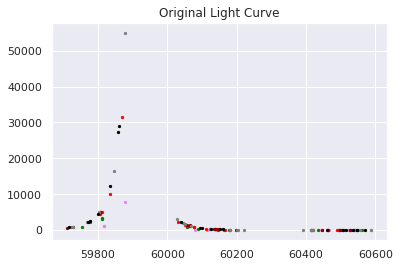

In [4]:
tempplt = plot_allbands_df(df)
tempplt.title("Original Light Curve")
tempplt.show()

This needs to be modified into a conventional time series having a constant length before being fed to the GP-VAE as input.

We choose the constant length to be 200 days as a heuristic, because that covers almost all transient activity based on our testing (using ```detected_bool=1```) (ToDo: EXPLAIN MORE)

If either of the following is true:
- More than 3 observations in a span of 5 consecutive days have a ratio >=2
- detected_bool = 1
then the light curve is cropped to a length of 200 days roughly centred about the point when either of the above happens.    

When neither of the above 2 criteria are fulfilled, the first 200 days are considered by default (ToDo: EXPLAIN MORE about why these criteria were chosen.)

In [5]:
def center_bigdf(df):
    '''
    If either of the following is true:
        - More than 3 observations in a span of 5 consecutive days have a ratio >=2
        - detected_bool = 1
    then the light curve is cropped to a length of 200 days roughly centred about the point when either of the above happens.
    
    When neither of the above 2 criteria are fulfilled, the first 200 days are considered by default

    '''
    
    # Start mjd from 0
    df["mjd"] = df["mjd"] - df["mjd"][0]
    df["ratio"] = abs(df["flux"]/df["fluxerr"])

    df["ratio2bool"] = 0

    subdf_detected = df[df["detected_bool"]==1]
    subdf_ratio2 = df[df["ratio"]>=2]

    # Find the mjd where more than 3 observations in a span of 5 consecutive days have a flux-fluxerr ratio >=2
    smalldf = subdf_ratio2.loc[abs(subdf_ratio2.mjd.diff(periods=-1))<=5]
    for i in range(3):
        smalldf = smalldf[abs(smalldf.mjd.diff(periods=-1))<=5]

    
    if len(subdf_detected)>0 and len(smalldf)>0:
        detected_bool_minmjd = subdf_detected.mjd.values[0]
        custom_bool_minmjd = smalldf.mjd.values[0]

        diffmjd = abs(detected_bool_minmjd - custom_bool_minmjd)/2

        minmjdstart = min(detected_bool_minmjd, custom_bool_minmjd)
        maxmjdstart = max(detected_bool_minmjd, custom_bool_minmjd)

        mjdlim_lower = minmjdstart - (100-diffmjd)
        mjdlim_upper = maxmjdstart + (100-diffmjd)

    elif len(subdf_detected)>0:
        detected_bool_minmjd = subdf_detected.mjd.values[0]
        mjdlim_lower = detected_bool_minmjd - 100
        mjdlim_upper = detected_bool_minmjd + 100

    elif len(smalldf)>0:
        custom_bool_minmjd = smalldf.mjd.values[0]
        mjdlim_lower = custom_bool_minmjd - 100
        mjdlim_upper = custom_bool_minmjd + 100

    else:
        mjdlim_lower = 0
        mjdlim_upper = 200
    
    # Lower limit can't be -ve
    if mjdlim_lower<0:
        mjdlim_upper = mjdlim_upper + abs(mjdlim_lower)
        mjdlim_lower = 0

    assert (mjdlim_upper-mjdlim_lower)==200
    
    df.loc[(df["mjd"] >= mjdlim_lower) & (df["mjd"] <= mjdlim_upper),"ratio2bool"] = 1
    
    newdf = df[df["ratio2bool"]==1].reset_index(drop=True)
    
    return newdf

In [6]:
newdf = center_bigdf(df)
newdf

,mjd,band,flux,fluxerr,detected_bool,ratio,ratio2bool
0,0.0000,i,571.036438,38.534260,1,14.818928,1
1,4.9189,Y,749.963562,32.526573,1,23.056950,1
2,11.8958,z,811.698425,33.418995,1,24.288535,1
3,18.0183,z,791.284973,46.716145,1,16.938148,1
4,18.8128,i,834.375305,28.976799,1,28.794599,1
5,42.7361,g,759.056091,23.736109,1,31.978960,1
6,58.7269,z,2148.493896,25.189192,1,85.294276,1
7,61.7802,Y,2285.122559,79.410194,1,28.776187,1
8,65.8392,z,2471.021973,27.277407,1,90.588595,1
9,66.8824,Y,2618.357910,46.559090,1,56.237309,1


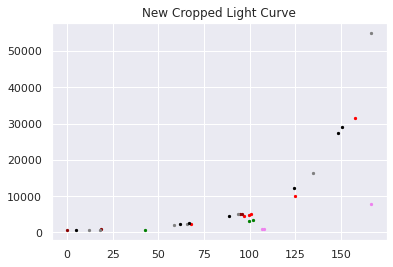

In [7]:
tempplt = plot_allbands_df(newdf)
tempplt.title("New Cropped Light Curve")
tempplt.show()


---
The full code for the above preprocessing and centering can be found on these GitHub repositories:
- https://github.com/siddharthchaini/centering-perfect-sims-resspect: Centering of RESSPECT Perfect Simulation Light Curves
- https://github.com/siddharthchaini/centering-time-series-plasticc: Centering of PLAsTiCC Data

**(NOTE: These will be ported over to the current repository soon. ToDo)**

### 2.3 Downloading the code for GP-VAE

Based on the TensorFlow version, different code will be used.

In [8]:
# Install GP-VAE

# import tensorflow as tf
# import subprocess
# tf_v = tf.__version__
# print(f"TF Version is: {tf_v}")

# if int(tf_v[0])==2:
#     git_url = "https://github.com/siddharthchaini/GP-VAE"
# elif int(tf_v[0])==1:
#     git_url = "https://github.com/ratschlab/GP-VAE"
    
    
# dl_loc = "../.repos/GP-VAE" # Directory where GP-VAE Code is saved / to be saved
# if not os.path.isdir(dl_loc):
#     print("Downloading ...")
#     # Download code
#     process = subprocess.run(["git","clone", git_url, dl_loc], stdout=subprocess.PIPE, universal_newlines=True)
#     if process.returncode == 0:
#         print("Downloaded successfully")
#     else:
#         print("Error downloading.")
#         print(process.stdout)
# else:
#     print("Already found GP-VAE directory")

In [9]:
# Change working directory to GP-VAE Raw
os.chdir("gpvae-raw")

This directory is based on https://github.com/siddharthchaini/gpvae-raw

### 2.3.1 Let's now implement GP-VAE for the Physionet data as described in [Fortuin et. al. (2020)](https://arxiv.org/pdf/1907.04155.pdf)

References: 
1. https://www.kaggle.com/siddharthchaini/gpvae-raw?scriptVersionId=67899219
2. https://www.kaggle.com/siddharthchaini/gpvae-raw-visualisation?scriptVersionId=68152622

In [31]:
from lib.models import *

#### 2.3.1.1 Download Physionet data

In [32]:
# Download only the first time

# !wget https://www.dropbox.com/s/651d86winb4cy9n/physionet.npz?dl=1 -O physionet.npz

assert os.path.isfile("physionet.npz")

#### 2.3.1.2 Imports

In [16]:
import sys

import os
import time
from datetime import datetime
import numpy as np
import matplotlib
matplotlib.use("Agg")
from matplotlib import pyplot as plt
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
from lib.models import *

#### 2.3.1.3 Flags

In [18]:
latent_dim = 35 # 'Dimensionality of the latent space'
encoder_sizes = [128, 128] # 'Layer sizes of the encoder'
decoder_sizes = [256, 256] # 'Layer sizes of the decoder'
window_size = 24 # 'Window size for the inference CNN: Ignored if model_type is not gp-vae'
sigma = 1.005 # 'Sigma value for the GP prior: Ignored if model_type is not gp-vae'
length_scale = 7.0 # 'Length scale value for the GP prior: Ignored if model_type is not gp-vae'
beta = 0.2 # 'Factor to weigh the KL term (similar to beta-VAE'
num_epochs = 40 # 'Number of training epochs'

# Flags with common default values for all three datasets
learning_rate = 1e-3 # 'Learning rate for training'
gradient_clip = 1e4 # 'Maximum global gradient norm for the gradient clipping during training'
num_steps = 0 # 'Number of training steps: If non-zero it overwrites num_epochs'
print_interval = 0 # 'Interval for printing the loss and saving the model during training'
exp_name = "reproduce_physionet" # 'Name of the experiment'
basedir = "models" # 'Directory where the models should be stored'
data_dir = "" # 'Directory from where the data should be read in'
data_type = 'physionet' # ['hmnist', 'physionet', 'sprites'], 'Type of data to be trained on'
seed = 1337 # 'Seed for the random number generator'
model_type = 'gp-vae' # ['vae', 'hi-vae', 'gp-vae'], 'Type of model to be trained'
cnn_kernel_size = 3 # 'Kernel size for the CNN preprocessor'
cnn_sizes = [256] # 'Number of filters for the layers of the CNN preprocessor'
testing = True # 'Use the actual test set for testing'
banded_covar = True # 'Use a banded covariance matrix instead of a diagonal one for the output of the inference network: Ignored if model_type is not gp-vae'
batch_size = 64 # 'Batch size for training'

M = 1 # 'Number of samples for ELBO estimation'
K = 1 # 'Number of importance sampling weights'

kernel = 'cauchy' # ['rbf', 'diffusion', 'matern', 'cauchy'], 'Kernel to be used for the GP prior: Ignored if model_type is not (mgp-vae'
kernel_scales = 1 # 'Number of different length scales sigma for the GP prior: Ignored if model_type is not gp-vae'

#### 2.3.1.4 Prep

In [19]:
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
print("Testing: ", testing, f"\t Seed: {seed}")

Testing:  True 	 Seed: 1337


In [20]:
encoder_sizes = [int(size) for size in encoder_sizes]
decoder_sizes = [int(size) for size in decoder_sizes]

if 0 in encoder_sizes:
    encoder_sizes.remove(0)
if 0 in decoder_sizes:
    decoder_sizes.remove(0)

In [21]:
# Make up full exp name
timestamp = datetime.now().strftime("%y%m%d")
full_exp_name = "{}_{}".format(timestamp, exp_name)
outdir = os.path.join(basedir, full_exp_name)
if not os.path.exists(outdir): os.mkdir(outdir)
checkpoint_prefix = os.path.join(outdir, "ckpt")
print("Full exp name: ", full_exp_name)

Full exp name:  210729_reproduce_physionet


#### 2.3.1.5 Define data specific parameters

In [22]:
data_type

'physionet'

In [23]:
if data_type == "hmnist":
    data_dir = "data/hmnist/hmnist_mnar.npz"
    data_dim = 784
    time_length = 10
    num_classes = 10
    decoder = BernoulliDecoder
    img_shape = (28, 28, 1)
    val_split = 50000
elif data_type == "physionet":
    if data_dir == "":
        data_dir = "physionet.npz"
    data_dim = 35
    time_length = 48
    num_classes = 2
    decoder = GaussianDecoder
elif data_type == "sprites":
    if data_dir == "":
        data_dir = "data/sprites/sprites.npz"
    data_dim = 12288
    time_length = 8
    decoder = GaussianDecoder
    img_shape = (64, 64, 3)
    val_split = 8000
else:
    raise ValueError("Data type must be one of ['hmnist', 'physionet', 'sprites']")

#### 2.3.1.6 Load data

In [24]:
data = np.load(data_dir)

In [25]:
x_train_full = data['x_train_full']
x_train_miss = data['x_train_miss']
m_train_miss = data['m_train_miss']

In [26]:
if data_type in ['hmnist', 'physionet']:
    y_train = data['y_train']

In [27]:
if testing:
    if data_type in ['hmnist', 'sprites']:
        x_val_full = data['x_test_full']
        x_val_miss = data['x_test_miss']
        m_val_miss = data['m_test_miss']
    if data_type == 'hmnist':
        y_val = data['y_test']
    elif data_type == 'physionet':
        x_val_full = data['x_train_full']
        x_val_miss = data['x_train_miss']
        m_val_miss = data['m_train_miss']
        y_val = data['y_train']
        m_val_artificial = data["m_train_artificial"]
elif data_type in ['hmnist', 'sprites']:
    x_val_full = x_train_full[val_split:]
    x_val_miss = x_train_miss[val_split:]
    m_val_miss = m_train_miss[val_split:]
    if data_type == 'hmnist':
        y_val = y_train[val_split:]
    x_train_full = x_train_full[:val_split]
    x_train_miss = x_train_miss[:val_split]
    m_train_miss = m_train_miss[:val_split]
    y_train = y_train[:val_split]
elif data_type == 'physionet':
    x_val_full = data["x_val_full"]  # full for artificial missings
    x_val_miss = data["x_val_miss"]
    m_val_miss = data["m_val_miss"]
    m_val_artificial = data["m_val_artificial"]
    y_val = data["y_val"]
else:
    raise ValueError("Data type must be one of ['hmnist', 'physionet', 'sprites']")

In [28]:
tf_x_train_miss = tf.data.Dataset.from_tensor_slices((x_train_miss, m_train_miss))\
                                 .shuffle(len(x_train_miss)).batch(batch_size).repeat()
tf_x_val_miss = tf.data.Dataset.from_tensor_slices((x_val_miss, m_val_miss)).batch(batch_size).repeat()
tf_x_val_miss = tf.compat.v1.data.make_one_shot_iterator(tf_x_val_miss)

In [29]:
# Build Conv2D preprocessor for image data
if data_type in ['hmnist', 'sprites']:
    print("Using CNN preprocessor")
    image_preprocessor = ImagePreprocessor(img_shape, cnn_sizes, cnn_kernel_size)
elif data_type == 'physionet':
    image_preprocessor = None
else:
    raise ValueError("Data type must be one of ['hmnist', 'physionet', 'sprites']")

#### 2.3.1.7 Build Model

In [30]:
if model_type == "vae":
    model = VAE(latent_dim=latent_dim, data_dim=data_dim, time_length=time_length,
                encoder_sizes=encoder_sizes, encoder=DiagonalEncoder,
                decoder_sizes=decoder_sizes, decoder=decoder,
                image_preprocessor=image_preprocessor, window_size=window_size,
                beta=beta, M=M, K=K)
elif model_type == "hi-vae":
    model = HI_VAE(latent_dim=latent_dim, data_dim=data_dim, time_length=time_length,
                   encoder_sizes=encoder_sizes, encoder=DiagonalEncoder,
                   decoder_sizes=decoder_sizes, decoder=decoder,
                   image_preprocessor=image_preprocessor, window_size=window_size,
                   beta=beta, M=M, K=K)
elif model_type == "gp-vae":
    encoder = BandedJointEncoder if banded_covar else JointEncoder
    model = GP_VAE(latent_dim=latent_dim, data_dim=data_dim, time_length=time_length,
                   encoder_sizes=encoder_sizes, encoder=encoder,
                   decoder_sizes=decoder_sizes, decoder=decoder,
                   kernel=kernel, sigma=sigma,
                   length_scale=length_scale, kernel_scales = kernel_scales,
                   image_preprocessor=image_preprocessor, window_size=window_size,
                   beta=beta, M=M, K=K, data_type=data_type)
else:
    raise ValueError("Model type must be one of ['vae', 'hi-vae', 'gp-vae']")

#### 2.3.1.8 Training preparation

In [20]:
print("GPU support: ", tf.test.is_gpu_available())

GPU support:  True


In [21]:
print("Training...")
_ = tf.compat.v1.train.get_or_create_global_step()
trainable_vars = model.get_trainable_vars()
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

print("Encoder: ", model.encoder.net.summary())
print("Decoder: ", model.decoder.net.summary())

Training...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (1, 48, 128)              107648    
_________________________________________________________________
dense (Dense)                (1, 48, 128)              16512     
_________________________________________________________________
dense_1 (Dense)              (1, 48, 105)              13545     
Total params: 137,705
Trainable params: 137,705
Non-trainable params: 0
_________________________________________________________________
Encoder:  None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (1, 48, 256)              9216      
_________________________________________________________________
dense_3 (Dense)              (1, 48, 256)              65792     
_

In [22]:
if model.preprocessor is not None:
    print("Preprocessor: ", model.preprocessor.net.summary())
    saver = tf.compat.v1.train.Checkpoint(optimizer=optimizer, encoder=model.encoder.net,
                                          decoder=model.decoder.net, preprocessor=model.preprocessor.net,
                                          optimizer_step=tf.compat.v1.train.get_or_create_global_step())
else:
    saver = tf.compat.v1.train.Checkpoint(optimizer=optimizer, encoder=model.encoder.net, decoder=model.decoder.net,
                                          optimizer_step=tf.compat.v1.train.get_or_create_global_step())

In [23]:
summary_writer = tf.compat.v2.summary.create_file_writer(logdir=outdir, flush_millis=10000)

In [24]:
if num_steps == 0:
    num_steps = num_epochs * len(x_train_miss) // batch_size
else:
    num_steps = num_steps

In [25]:
if print_interval == 0:
    print_interval = num_steps // num_epochs

#### 2.3.1.9 Training

In [26]:
losses_train = []
losses_val = []

In [27]:
t0 = time.time()

In [28]:
with summary_writer.as_default(), tf.compat.v2.summary.record_if(True):
    for i, (x_seq, m_seq) in enumerate(tf_x_train_miss.take(num_steps)):
        try:
            with tf.GradientTape() as tape:
                tape.watch(trainable_vars)
                loss = model.compute_loss(x_seq, m_mask=m_seq)
                losses_train.append(loss.numpy())
            grads = tape.gradient(loss, trainable_vars)
            grads = [np.nan_to_num(grad) for grad in grads]
            grads, global_norm = tf.clip_by_global_norm(grads, gradient_clip)
            optimizer.apply_gradients(zip(grads, trainable_vars),
                                      global_step=tf.compat.v1.train.get_or_create_global_step())

            # Print intermediate results
            if i % print_interval == 0:
                print("================================================")
                print("Learning rate: {} | Global gradient norm: {:.2f}".format(optimizer._lr, global_norm))
                print("Step {}) Time = {:2f}".format(i, time.time() - t0))
                loss, nll, kl = model.compute_loss(x_seq, m_mask=m_seq, return_parts=True)
                print("Train loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(loss, nll, kl))

                saver.save(checkpoint_prefix)
                tf.compat.v2.summary.scalar(name="loss_train", data=loss, step=tf.compat.v1.train.get_or_create_global_step())
                tf.compat.v2.summary.scalar(name="kl_train", data=kl, step=tf.compat.v1.train.get_or_create_global_step())
                tf.compat.v2.summary.scalar(name="nll_train", data=nll, step=tf.compat.v1.train.get_or_create_global_step())

                # Validation loss
                x_val_batch, m_val_batch = tf_x_val_miss.get_next()
                val_loss, val_nll, val_kl = model.compute_loss(x_val_batch, m_mask=m_val_batch, return_parts=True)
                losses_val.append(val_loss.numpy())
                print("Validation loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(val_loss, val_nll, val_kl))

                tf.compat.v2.summary.scalar(name="loss_val", data=val_loss, step=tf.compat.v1.train.get_or_create_global_step())
                tf.compat.v2.summary.scalar(name="kl_val", data=val_kl, step=tf.compat.v1.train.get_or_create_global_step())
                tf.compat.v2.summary.scalar(name="nll_val", data=val_nll, step=tf.compat.v1.train.get_or_create_global_step())

                if data_type in ["hmnist", "sprites"]:
                    # Draw reconstructed images
                    x_hat = model.decode(model.encode(x_seq).sample()).mean()
                    tf.compat.v2.summary.image(name="input_train", data=tf.reshape(x_seq, [-1]+list(img_shape)), step=tf.compat.v1.train.get_or_create_global_step())
                    tf.compat.v2.summary.image(name="reconstruction_train", data=tf.reshape(x_hat, [-1]+list(img_shape)), step=tf.compat.v1.train.get_or_create_global_step())
                elif data_type == 'physionet':
                    # Eval MSE and AUROC on entire val set
                    x_val_miss_batches = np.array_split(x_val_miss, batch_size, axis=0)
                    x_val_full_batches = np.array_split(x_val_full, batch_size, axis=0)
                    m_val_artificial_batches = np.array_split(m_val_artificial, batch_size, axis=0)
                    get_val_batches = lambda: zip(x_val_miss_batches, x_val_full_batches, m_val_artificial_batches)

                    n_missings = m_val_artificial.sum()
                    mse_miss = np.sum([model.compute_mse(x, y=y, m_mask=m).numpy()
                                       for x, y, m in get_val_batches()]) / n_missings

                    x_val_imputed = np.vstack([model.decode(model.encode(x_batch).mean()).mean().numpy()
                                               for x_batch in x_val_miss_batches])
                    x_val_imputed[m_val_miss == 0] = x_val_miss[m_val_miss == 0]  # impute gt observed values

                    x_val_imputed = x_val_imputed.reshape([-1, time_length * data_dim])
                    val_split = len(x_val_imputed) // 2
                    cls_model = LogisticRegression(solver='liblinear', tol=1e-10, max_iter=10000)
                    cls_model.fit(x_val_imputed[:val_split], y_val[:val_split])
                    probs = cls_model.predict_proba(x_val_imputed[val_split:])[:, 1]
                    auroc = roc_auc_score(y_val[val_split:], probs)
                    print("MSE miss: {:.4f} | AUROC: {:.4f}".format(mse_miss, auroc))

                    # Update learning rate (used only for physionet with decay=0.5)
                    if i > 0 and i % (10*print_interval) == 0:
                        optimizer._lr = max(0.5 * optimizer._lr, 0.1 * learning_rate)
                t0 = time.time()
        except KeyboardInterrupt as e:
            print("KeyboardInterrupt")
            saver.save(checkpoint_prefix)
#             if debug:
#                 import ipdb
#                 ipdb.set_trace()
            break

Learning rate: 0.001 | Global gradient norm: 9908.78
Step 0) Time = 1.067125
Train loss = 59556.738 | NLL = 433.687 | KL = 295615.250
Validation loss = 59752.488 | NLL = 420.138 | KL = 296661.750
MSE miss: 1.0416 | AUROC: 0.6671
Learning rate: 0.001 | Global gradient norm: 1077.27
Step 62) Time = 15.317358
Train loss = 22612.756 | NLL = 365.161 | KL = 111237.984
Validation loss = 22203.000 | NLL = 357.304 | KL = 109228.469
MSE miss: 0.7399 | AUROC: 0.6958
Learning rate: 0.001 | Global gradient norm: 1534.75
Step 124) Time = 14.760513
Train loss = 21929.746 | NLL = 444.877 | KL = 107424.344
Validation loss = 21805.504 | NLL = 376.892 | KL = 107143.055
MSE miss: 0.7357 | AUROC: 0.6947
Learning rate: 0.001 | Global gradient norm: 326.75
Step 186) Time = 14.234811
Train loss = 21742.395 | NLL = 403.115 | KL = 106696.391
Validation loss = 21695.477 | NLL = 341.212 | KL = 106771.328
MSE miss: 0.6932 | AUROC: 0.7000
Learning rate: 0.001 | Global gradient norm: 200.83
Step 248) Time = 14.81786

#### 2.3.1.10 Evaluation

In [29]:
# Split data on batches
x_val_miss_batches = np.array_split(x_val_miss, batch_size, axis=0)
x_val_full_batches = np.array_split(x_val_full, batch_size, axis=0)

In [30]:
if data_type == 'physionet':
    m_val_batches = np.array_split(m_val_artificial, batch_size, axis=0)
else:
    m_val_batches = np.array_split(m_val_miss, batch_size, axis=0)

In [31]:
get_val_batches = lambda: zip(x_val_miss_batches, x_val_full_batches, m_val_batches)

In [32]:
# Compute NLL and MSE on missing values
n_missings = m_val_artificial.sum() if data_type == 'physionet' else m_val_miss.sum()
nll_miss = np.sum([model.compute_nll(x, y=y, m_mask=m).numpy()
                   for x, y, m in get_val_batches()]) / n_missings
mse_miss = np.sum([model.compute_mse(x, y=y, m_mask=m, binary=data_type=="hmnist").numpy()
                   for x, y, m in get_val_batches()]) / n_missings

In [33]:
print("NLL miss: {:.4f}".format(nll_miss))
print("MSE miss: {:.4f}".format(mse_miss))

NLL miss: 1.2348
MSE miss: 0.5735


In [34]:
# Save imputed values
z_mean = [model.encode(x_batch).mean().numpy() for x_batch in x_val_miss_batches]
np.save(os.path.join(outdir, "z_mean"), np.vstack(z_mean))
x_val_imputed = np.vstack([model.decode(z_batch).mean().numpy() for z_batch in z_mean])
x_val_imputed_std = np.vstack([model.decode(z_batch).stddev().numpy() for z_batch in z_mean])
np.save(os.path.join(outdir, "imputed_no_gt"), x_val_imputed)
np.save(os.path.join(outdir, "x_val_imputed_std"), x_val_imputed_std)

In [35]:
# impute gt observed values
x_val_imputed[m_val_miss == 0] = x_val_miss[m_val_miss == 0]
np.save(os.path.join(outdir, "imputed"), x_val_imputed)

In [36]:
if data_type == "hmnist":
    # AUROC evaluation using Logistic Regression
    x_val_imputed = np.round(x_val_imputed)
    x_val_imputed = x_val_imputed.reshape([-1, time_length * data_dim])

    cls_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', tol=1e-10, max_iter=10000)
    val_split = len(x_val_imputed) // 2

    cls_model.fit(x_val_imputed[:val_split], y_val[:val_split])
    probs = cls_model.predict_proba(x_val_imputed[val_split:])

    auprc = average_precision_score(np.eye(num_classes)[y_val[val_split:]], probs)
    auroc = roc_auc_score(np.eye(num_classes)[y_val[val_split:]], probs)
    print("AUROC: {:.4f}".format(auroc))
    print("AUPRC: {:.4f}".format(auprc))

elif data_type == "sprites":
    auroc, auprc = 0, 0

elif data_type == "physionet":
    # Uncomment to preserve some z_samples and their reconstructions
    # for i in range(5):
    #     z_sample = [model.encode(x_batch).sample().numpy() for x_batch in x_val_miss_batches]
    #     np.save(os.path.join(outdir, "z_sample_{}".format(i)), np.vstack(z_sample))
    #     x_val_imputed_sample = np.vstack([model.decode(z_batch).mean().numpy() for z_batch in z_sample])
    #     np.save(os.path.join(outdir, "imputed_sample_{}_no_gt".format(i)), x_val_imputed_sample)
    #     x_val_imputed_sample[m_val_miss == 0] = x_val_miss[m_val_miss == 0]
    #     np.save(os.path.join(outdir, "imputed_sample_{}".format(i)), x_val_imputed_sample)

    # AUROC evaluation using Logistic Regression
    x_val_imputed = x_val_imputed.reshape([-1, time_length * data_dim])
    val_split = len(x_val_imputed) // 2
    cls_model = LogisticRegression(solver='liblinear', tol=1e-10, max_iter=10000)
    cls_model.fit(x_val_imputed[:val_split], y_val[:val_split])
    probs = cls_model.predict_proba(x_val_imputed[val_split:])[:, 1]
    auprc = average_precision_score(y_val[val_split:], probs)
    auroc = roc_auc_score(y_val[val_split:], probs)

    print("AUROC: {:.4f}".format(auroc))
    print("AUPRC: {:.4f}".format(auprc))

AUROC: 0.7388
AUPRC: 0.3402


In [37]:
# Visualize reconstructions
if data_type in ["hmnist", "sprites"]:
    img_index = 0
    if data_type == "hmnist":
        img_shape = (28, 28)
        cmap = "gray"
    elif data_type == "sprites":
        img_shape = (64, 64, 3)
        cmap = None

    fig, axes = plt.subplots(nrows=3, ncols=x_val_miss.shape[1], figsize=(2*x_val_miss.shape[1], 6))

    x_hat = model.decode(model.encode(x_val_miss[img_index: img_index+1]).mean()).mean().numpy()
    seqs = [x_val_miss[img_index:img_index+1], x_hat, x_val_full[img_index:img_index+1]]

    for axs, seq in zip(axes, seqs):
        for ax, img in zip(axs, seq[0]):
            ax.imshow(img.reshape(img_shape), cmap=cmap)
            ax.axis('off')

    suptitle = model_type + f" reconstruction, NLL missing = {mse_miss}"
    fig.suptitle(suptitle, size=18)
    fig.savefig(os.path.join(outdir, data_type + "_reconstruction.pdf"))

results_all = [seed, model_type, data_type, kernel, beta, latent_dim,
               num_epochs, batch_size, learning_rate, window_size,
               kernel_scales, sigma, length_scale,
               len(encoder_sizes), encoder_sizes[0] if len(encoder_sizes) > 0 else 0,
               len(decoder_sizes), decoder_sizes[0] if len(decoder_sizes) > 0 else 0,
               cnn_kernel_size, cnn_sizes,
               nll_miss, mse_miss, losses_train[-1], losses_val[-1], auprc, auroc, testing, data_dir]

with open(os.path.join(outdir, "results.tsv"), "w") as outfile:
    outfile.write("seed\tmodel\tdata\tkernel\tbeta\tz_size\tnum_epochs"
                  "\tbatch_size\tlearning_rate\twindow_size\tkernel_scales\t"
                  "sigma\tlength_scale\tencoder_depth\tencoder_width\t"
                  "decoder_depth\tdecoder_width\tcnn_kernel_size\t"
                  "cnn_sizes\tNLL\tMSE\tlast_train_loss\tlast_val_loss\tAUPRC\tAUROC\ttesting\tdata_dir\n")
    outfile.write("\t".join(map(str, results_all)))

with open(os.path.join(outdir, "training_curve.tsv"), "w") as outfile:
    outfile.write("\t".join(map(str, losses_train)))
    outfile.write("\n")
    outfile.write("\t".join(map(str, losses_val)))

print("Training finished.")

Training finished.


#### 2.3.1.10 Visaualising Results

In [34]:
x_val_full[x_val_full == 0] = 'nan'
imputed = np.load("models/210710_reproduce_physionet/imputed.npy")
x_val_imputed_std = np.load("models/210710_reproduce_physionet/x_val_imputed_std.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'models/210710_reproduce_physionet/imputed.npy'

---

TODO

---

### Let's now try to apply it to RESSPECT Simulation Data

References: 
1. https://www.kaggle.com/siddharthchaini/gpvae-raw-plasticc?scriptVersionId=66968645
2. https://www.kaggle.com/siddharthchaini/visualisation-gpvae-raw-plasticc?scriptVersionId=67006906